# 월간 데이콘 항공편 지연 예측 AI 경진대회
https://dacon.io/competitions/official/236094/overview/description

## 23-1학기 빅데이터처리 기말 프로젝트
### 팀원
- 이시내
- 유동혁
- 김명학
- 박준수
--- 
### 이 후 수정 방법:
1. ['Delay_per']의 평균을 내서 상위 50퍼는 Delayed로 간주, ['Delay_num']에 삽입
    - 0.6821020302점 달성.
2. labeled['Delay_num']의 평균을 내서 (약 0.17647), 상위 20%의 ['Delay_per']를 Delayed로 간주
    - 0.7751130567점 달성
3. 전처리 이후 train['Delay_per'](dtype = float)만 이용해서 no tune xgboost 실행
    - 0.7464493418점 달성
4. 전처리 과정 중 unlabeled의 전체를 한번에 채워넣는 것이 아니라, unlabeled를 여러 조각으로 나눠 조금씩 labeled에 합침
    - 0.6857301445점 달성
5. 나눠서 학습하는 과정에서 labeled['Delay_per']를 기준으로 학습하고 전체 평균을 기준으로 train['Delay_num']을 채워넣음
    - 0.6561362148점 달성
6. EDT, EAT 데이터 전처리 후 학습
    - public: 0.6337836841점, private: 0.7080757848점
7. 대회 종료 후, [private점수 1위의 코드](https://dacon.io/competitions/official/236094/codeshare/8341)를 참고하여 수정 및 개선한 모델
    - public: 0.6234701617점, private: 0.7169214489점


In [1]:
# 경고메세지 끄기
import warnings
warnings.filterwarnings(action='ignore')

# 프로그램 시간 측정
import math
import time
import datetime
time_start =  time.time()
print('시작 시각:', time.strftime('%Y.%m.%d - %H:%M:%S'))

시작 시각: 2023.06.02 - 12:42:51


In [2]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import random
import os
import gc

from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from collections import defaultdict

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

## 데이터 불러오기

In [4]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

# csv_to_parquet('./train.csv', 'train')
# csv_to_parquet('./test.csv', 'test')

In [5]:
train = pd.read_parquet('./train.parquet')
test = pd.read_parquet('./test.parquet')
sample_submission = pd.read_csv('sample_submission.csv', index_col = 0)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  890981 non-null   float64
 4   Estimated_Arrival_Time    890960 non-null   float64
 5   Cancelled                 1000000 non-null  int64  
 6   Diverted                  1000000 non-null  int64  
 7   Origin_Airport            1000000 non-null  object 
 8   Origin_Airport_ID         1000000 non-null  int64  
 9   Origin_State              890985 non-null   object 
 10  Destination_Airport       1000000 non-null  object 
 11  Destination_Airport_ID    1000000 non-null  int64  
 12  Destination_State         890921 non-null   object 
 13  Distance                  10

In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 18 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   ID                        1000000 non-null  object 
 1   Month                     1000000 non-null  int64  
 2   Day_of_Month              1000000 non-null  int64  
 3   Estimated_Departure_Time  891016 non-null   float64
 4   Estimated_Arrival_Time    890952 non-null   float64
 5   Cancelled                 1000000 non-null  int64  
 6   Diverted                  1000000 non-null  int64  
 7   Origin_Airport            1000000 non-null  object 
 8   Origin_Airport_ID         1000000 non-null  int64  
 9   Origin_State              893495 non-null   object 
 10  Destination_Airport       1000000 non-null  object 
 11  Destination_Airport_ID    1000000 non-null  int64  
 12  Destination_State         893477 non-null   object 
 13  Distance                  10

In [8]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, TEST_000000 to TEST_999999
Data columns (total 2 columns):
 #   Column       Non-Null Count    Dtype
---  ------       --------------    -----
 0   Not_Delayed  1000000 non-null  int64
 1   Delayed      1000000 non-null  int64
dtypes: int64(2)
memory usage: 22.9+ MB


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# 히트맵으로 상관관계 표시
plt.figure(figsize = (12,12))
sns.heatmap(labeled.drop(columns=['ID', 'Delay']).corr(), annot = True, cmap = 'Blues')
plt.show()

## 데이터 전처리 과정

#### 1. Delay열을 제외한 열에 존재하는 결측값을 채웁니다.

##### 1-1. EDT, EAT의 전처리를 진행합니다. 

In [9]:
#EDT, EAT가 모두 결측값인 행 제거
train = train.dropna(subset=['Estimated_Departure_Time', 'Estimated_Arrival_Time'], how='all')

In [10]:
# Arrival Time & Departure Time 둘 다 60분 * 24 = 1440 계로 바꿔주기
def to_minutes(x):
    x = int(x)
    x = str(x)
    if len(x) > 2:
        hours, mins = int(x[:-2]), int(x[-2:])
    else:
        hours, mins = 0, int(x[-2:])
    return hours*60+mins

estimated_times = ['Estimated_Departure_Time', 'Estimated_Arrival_Time']

for ET in estimated_times:
    cond = ~train[ET].isnull()
    train.loc[cond, ET] = train.loc[cond, ET].apply(lambda x: to_minutes(x))
    cond2 = ~test[ET].isnull()
    test.loc[cond2, ET] = test.loc[cond2, ET].apply(lambda x: to_minutes(x))

In [11]:
# (OAID, DAID)를 키로 갖고, 평균 비행시간을 값으로 갖는 dictionary 만들기
time_flying = defaultdict(int)
time_number = defaultdict(int)

cond_arr2 = ~train['Estimated_Arrival_Time'].isnull()
cond_dep2 = ~train['Estimated_Departure_Time'].isnull()

for _, row in train.loc[cond_arr2 & cond_dep2, :].iterrows():
    OAID, DAID = row['Origin_Airport_ID'], row['Destination_Airport_ID']
    time_flying[(OAID,DAID)] += (row['Estimated_Arrival_Time'] - row['Estimated_Departure_Time'])%1440 # 하루 최대는 1440분
    time_number[(OAID,DAID)] += 1
    
    
for key in time_flying.keys():
    time_flying[key] /= time_number[key]

In [12]:
# Dictionary를 이용해 EAT, EDT 복구
for index, row in train.loc[train['Estimated_Departure_Time'].isnull(),].iterrows():
    OAID, DAID = row['Origin_Airport_ID'], row['Destination_Airport_ID']
    train.loc[index,'Estimated_Departure_Time'] = \
        (train.loc[index]['Estimated_Arrival_Time'] - time_flying[(OAID, DAID)])%1440
    
for index, row in train.loc[train['Estimated_Arrival_Time'].isnull(),].iterrows():
    OAID, DAID = row['Origin_Airport_ID'], row['Destination_Airport_ID']
    train.loc[index,'Estimated_Arrival_Time'] = \
        (train.loc[index]['Estimated_Departure_Time'] + time_flying[(OAID, DAID)])%1440

test data의 경우 복구 안 된 row를 빼 버리면 안됩니다. 복구 안된 row도 예측을 해야되기 때문이죠.
따라서, EAT, EDT 둘 다 없는 row는 각각의 최빈값을 채워주도록 하고 나머지는 복구를 해줍니다.

In [13]:
# (Test Data Only)
# 둘 다 없으면 최빈값으로 대체
cond_1 = test['Estimated_Departure_Time'].isnull()
cond_2 = test['Estimated_Arrival_Time'].isnull()

mode = test['Estimated_Departure_Time'].mode()[0]
mode2 = test['Estimated_Arrival_Time'].mode()[0]
test.loc[cond_1&cond_2, ['Estimated_Departure_Time', 'Estimated_Arrival_Time']] = mode, mode2


# Departure만 없을 때,
for index, row in test.loc[test['Estimated_Departure_Time'].isnull(),].iterrows():
    OAID, DAID = row['Origin_Airport_ID'], row['Destination_Airport_ID']
    test.loc[index,'Estimated_Departure_Time'] = \
        (test.loc[index]['Estimated_Arrival_Time'] - time_flying[(OAID, DAID)])%1440
    

# Arrival만 없을 때,
for index, row in test.loc[test['Estimated_Arrival_Time'].isnull(),].iterrows():
    OAID, DAID = row['Origin_Airport_ID'], row['Destination_Airport_ID']
    test.loc[index,'Estimated_Arrival_Time'] = \
        (test.loc[index]['Estimated_Departure_Time'] + time_flying[(OAID, DAID)])%1440

    
# 모두 int로 바꾼다.
estimated_times = ['Estimated_Departure_Time', 'Estimated_Arrival_Time']
train = train.astype({'Estimated_Departure_Time':int, 'Estimated_Arrival_Time':int})
test = test.astype({'Estimated_Departure_Time':int, 'Estimated_Arrival_Time':int})
for ET in estimated_times:
    train.loc[train[ET] == 1440, ET] = 0
    test.loc[test[ET] == 1440, ET] = 0


print("EDT, EAT Done.")

EDT, EAT Done.


사람이 붐비는 특정 시간이 비행기 연착에 영향을 줄 수도 있으므로, EDT, EAT를 30분단위로 48개의 구간에 넣습니다.

In [14]:
# EDT, EAT 48개의 bins에 담으면 된다. 1440(60*24) 계니까, 48씩 끊어서 하면 될 듯
estimated_times = ['Estimated_Departure_Time', 'Estimated_Arrival_Time']
names = {'Estimated_Departure_Time':'EDT', 'Estimated_Arrival_Time':'EAT'}
for ET in estimated_times:
    for i in range(48):
        train.loc[train[ET].between(i*30, (i+1)*30, 'left'), names[ET]] = i
        test.loc[test[ET].between(i*30, (i+1)*30, 'left'), names[ET]] = i

train = train.astype({'EDT':int, 'EAT':int})
test = test.astype({'EDT':int, 'EAT':int})

train = train.drop(['Estimated_Departure_Time', 'Estimated_Arrival_Time'], axis=1)
test = test.drop(['Estimated_Departure_Time', 'Estimated_Arrival_Time'], axis=1)

print("EDT, EAT Done.")

EDT, EAT Done.


##### 1-2. Month, Days 처리
날짜를 366(윤년 고려)일 형식으로 변환합니다.

In [15]:
def to_days(x):
    month_to_days = {1:0, 2:31, 3:60, 4:91, 5:121, 6:152, 7:182, 8:213, 9:244, 10:274, 11:305, 12:335}
    return month_to_days[x]

train.loc[:, 'Day'] = train['Month'].apply(lambda x: to_days(x))
train['Day'] = train['Day'] + train['Day_of_Month']

test.loc[:, 'Day'] = test['Month'].apply(lambda x: to_days(x))
test['Day'] = test['Day'] + test['Day_of_Month']

train = train.astype({'Day':'int64'})
test = test.astype({'Day':'int64'})

print("Day Done.")

Day Done.


##### 1-3 Carrier_ID(DOT)의 결측값을 Airline으로 채워넣기
데이터 설명에 따르면 Carrier_ID(DOT)는 Airline별로 하나가 할당되어 1대1 대응하기 때문에, 숫자 형태인 Carrier_ID(DOT)를 복구해봅니다.

In [16]:
# 복구 가능한 Carrier_ID(DOT)의 개수를 구합니다.
cond1 = train['Carrier_ID(DOT)'].isnull()
cond2 = ~train['Airline'].isnull()
print("Carrier_ID(DOT) 복구 가능한 데이터의 개수 :", len(train.loc[cond1 & cond2, :]))

Carrier_ID(DOT) 복구 가능한 데이터의 개수 : 95982


In [17]:
# airline to carrier id, dictinary 만들기
# 모두 데이터가 존재하는 열에서 Dict[Airline] = carrier_ID(DOT) 가 되도록 dictionary 생성
airline_to_cid = {}
for _, row in train[(~train['Carrier_ID(DOT)'].isnull() & ~train['Airline'].isnull())].iterrows():
    airline_to_cid[row['Airline']] = row['Carrier_ID(DOT)']

In [18]:
# Carrier_ID(DOT) 복구하기
def to_cid(x):
    return airline_to_cid[x]

cond1 = train['Carrier_ID(DOT)'].isnull()
cond2 = ~train['Airline'].isnull()
train.loc[cond1&cond2, 'Carrier_ID(DOT)'] = train.loc[cond1&cond2, 'Airline'].apply(lambda x: to_cid(x))

In [19]:
# 복구 안 된 row 빼기
train = train.dropna(subset=['Carrier_ID(DOT)'], how='any', axis=0)

test data는 복구 안 된 row를 삭제하면 안되기 때문에,    
train data와 같은 방법으로 복구가 불가능한 row는 최빈값으로 채워줍니다.

In [20]:
# (Test Data Only)
# Airline, Carrier_Code 둘 다 없으면 최빈 값으로 대체
NaN_col = ['Carrier_ID(DOT)']
cond1 = test['Airline'].isnull()
cond2 = test['Carrier_ID(DOT)'].isnull()

for col in NaN_col:
    mode = test[col].mode()[0]
    test.loc[cond1&cond2, col] = mode

# 나머진 Airline에서 대체
cond1 = test['Carrier_ID(DOT)'].isnull()
cond2 = ~test['Airline'].isnull()
test.loc[cond1&cond2, 'Carrier_ID(DOT)'] = test.loc[cond1&cond2, 'Airline'].apply(lambda x: to_cid(x))

print("Cid Done.")

Cid Done.


##### 1-4 Distance 처리
Distance가 너무 세세하므로 100단위로 끊어 50개의 구간에 넣어 정리합니다

In [21]:
for i in range(51):
    train.loc[train['Distance'].between(i*100, (i+1)*100, 'left'), 'Distance'] = i
    test.loc[test['Distance'].between(i*100, (i+1)*100, 'left'), 'Distance'] = i

train = train.astype({'Distance':int})
test = test.astype({'Distance':int})

print("distance Done.")

distance Done.


##### 1-5 필요 없는 Columns 제거
Month, Day_of_Month 는 Day의 데이터로 합쳐졌으니 제거합니다.    
Cancelled, Diverted 는 모두 0이므로 의미없는 값이므로 제거합니다.   
Origin_Airport, Destination_Airport 는 Origin_Airport_ID와    Destination_Airport_ID와 1대1대응 이므로 제거합니다.   
Carrier_Code(IATA)는 Airline 별로 N:1로 할당 된 값이므로, 큰 의미가 없습니다. 제거합니다.   
State 정보 보다는 Origin_Airport_ID가 중요하다고 생각되어서 (미국 주는 너무 커서 의미가 없다고 생각했음) 제거했습니다.   

In [22]:
col_drop = ['Month', 'Day_of_Month', 'Cancelled', 'Diverted', 'Origin_Airport', 'Destination_Airport', 'Carrier_Code(IATA)', 'Airline', 'Origin_State', 'Destination_State']
train = train.drop(col_drop, axis=1)
test = test.drop(col_drop, axis=1)
print("Drop Done.")

Drop Done.


#### 2. LabelEncoder를 이용해, 질적 변수들을 수치화합니다.


In [23]:
qual_col = ['Tail_Number']

for i in qual_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])
print('qual_col Done.')

qual_col Done.


전처리 완료 후 train과 test의 info 확인

In [24]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 976567 entries, 1 to 999999
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ID                      976567 non-null  object 
 1   Origin_Airport_ID       976567 non-null  int64  
 2   Destination_Airport_ID  976567 non-null  int64  
 3   Distance                976567 non-null  int32  
 4   Carrier_ID(DOT)         976567 non-null  float64
 5   Tail_Number             976567 non-null  int32  
 6   Delay                   249021 non-null  object 
 7   EDT                     976567 non-null  int32  
 8   EAT                     976567 non-null  int32  
 9   Day                     976567 non-null  int64  
dtypes: float64(1), int32(4), int64(3), object(2)
memory usage: 67.1+ MB


In [25]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   ID                      1000000 non-null  object 
 1   Origin_Airport_ID       1000000 non-null  int64  
 2   Destination_Airport_ID  1000000 non-null  int64  
 3   Distance                1000000 non-null  int32  
 4   Carrier_ID(DOT)         1000000 non-null  float64
 5   Tail_Number             1000000 non-null  int32  
 6   EDT                     1000000 non-null  int32  
 7   EAT                     1000000 non-null  int32  
 8   Day                     1000000 non-null  int64  
dtypes: float64(1), int32(4), int64(3), object(1)
memory usage: 53.4+ MB


#### 3. Delay 열에 결측값이 없는 행들과 있는 행들을 분리합니다.

In [26]:
labeled = train.dropna(subset=['Delay'])
unlabeled = train[train['Delay'].isnull()]

print(train.shape)
print(labeled.shape)
print(unlabeled.shape)

(976567, 10)
(249021, 10)
(727546, 10)


#### 4. Delay 열의 값이 string 형태이기 때문에 이를 0 또는 1로 변환합니다.

In [27]:
column_number = {}
for i, column in enumerate(sample_submission.columns):
    column_number[column] = i
# ==> column_number: {'Not_Delayed': 0, 'Delayed': 1}
    
def to_number(x, dic):
    return dic[x]

labeled.loc[:, 'Delay_num'] = labeled['Delay'].apply(lambda x: to_number(x, column_number))
# Delay 열의 값에 따라서, Not_Delayed면 0, Delayed면 1이 Delay_num 열에 저장됨
print('Delay_num Done.')

# 위 전체 과정은 아래 코드와 같은 의미임
# labeled['Delay_num'] = labeled['Delay'].apply(lambda x: 1 if x == 'Delayed' else 0)

Delay_num Done.


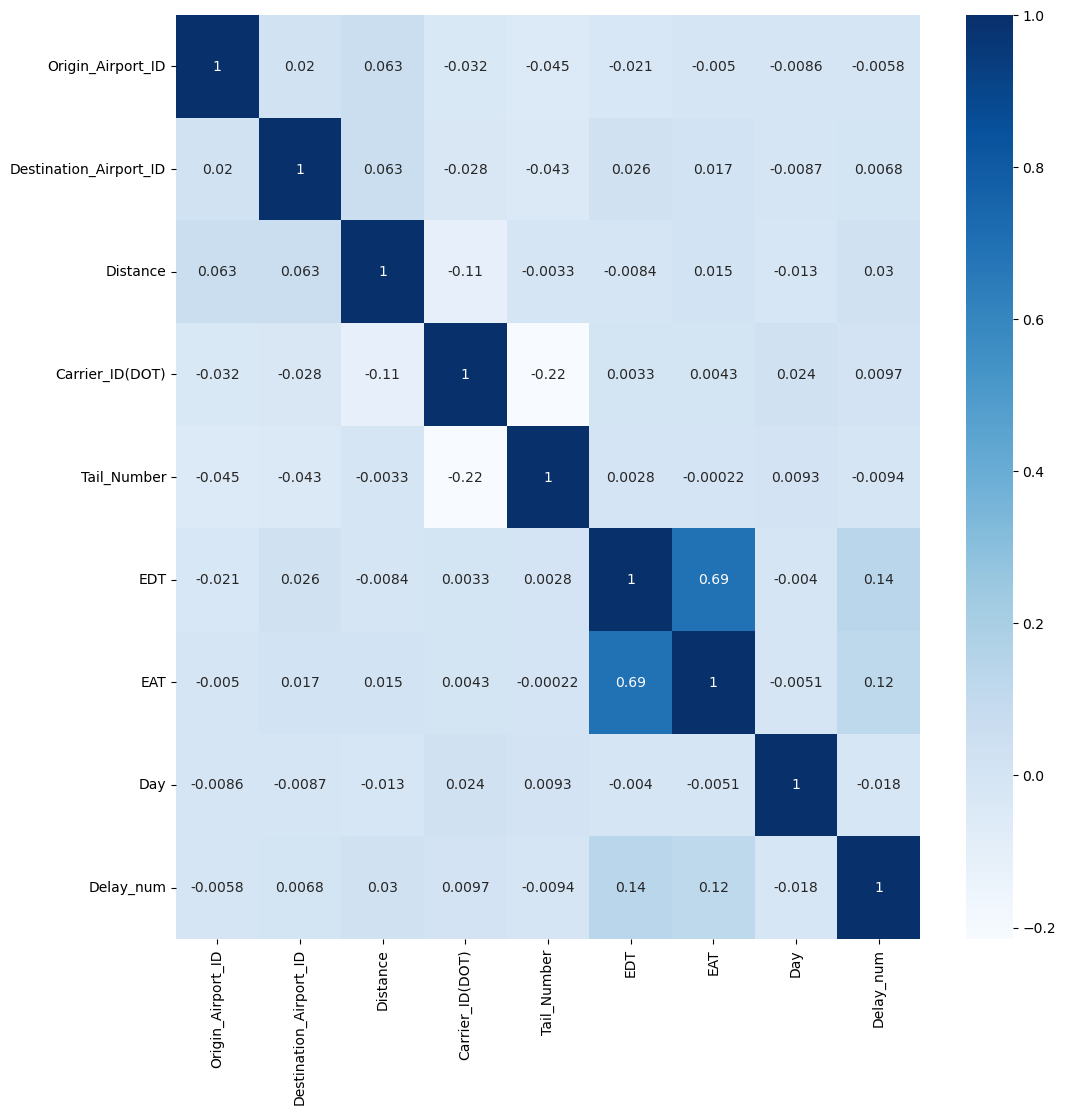

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
# 히트맵으로 상관관계 표시
plt.figure(figsize = (12,12))
sns.heatmap(labeled.drop(columns=['ID', 'Delay']).corr(), annot = True, cmap = 'Blues')
plt.show()

#### 5. 레이블이 없는 데이터의 `['Delay_num']`열을 채우기 위해 아래 과정을 거칩니다.
1. 먼저 `unlabeled`를 여러 구간으로 쪼갭니다. 여기서는 20개의 구간으로 쪼갰습니다.
2. 해당 항공편이 지연될 확률을 의미하는 `['Delay_per']`열을 만듭니다.
3. `labeled`를 XGBoost 모델에 학습시켜, `unlabeled`의 하나의 구간의 `['Delay_per']`열을 채워넣습니다.
4. `['Delay_per']`열이 채워진 `unlabeled` 구간을 `labeled`에 합칩니다.
5. 3, 4의 과정을 `unlabeled`데이터에 결측치가 없을 때까지 반복합니다.
6. `['Delay_per']`열의 평균값을 구해, 이 평균값보다 지연될 확률이 낮은 항공편은 <i>Not_Delayed</i>로 간주하고, 높은 항공편은 <i>Delayed</i>로 간주해 `['Delay_num']`열의 결측치를 채워 넣습니다.

In [29]:
labeled['Not_Delay_per'] = labeled['Delay_num'].apply(lambda x: 1 if x == 0 else 0).astype('float64')
labeled['Delay_per'] = labeled['Delay_num'].astype('float64')

num_of_gugan = 20
for i in range(num_of_gugan):
    gugan_size = int(round(len(unlabeled)/num_of_gugan, 0))
    L = gugan_size * i
    R = gugan_size * (i+1)
    
    small_unlabeled = unlabeled.iloc[L:R]
    
    # 레이블이 있는 데이터의 입력 변수와 출력 변수를 각각 labeled_x와 labeled_y로 저장
    labeled_x = labeled.drop(columns=['ID', 'Delay', 'Delay_num', 'Not_Delay_per', 'Delay_per'])
    labeled_y = labeled['Delay_per']

    # 레이블이 없는 데이터의 입력 변수를 unlabeled_x로 저장
    unlabeled_x = small_unlabeled.drop(columns=['ID', 'Delay'])

    # XGBoost 모델의 입력 데이터 형식인 DMatrix로 변환
    dtrain = xgb.DMatrix(labeled_x, label=labeled_y)
    dtest = xgb.DMatrix(unlabeled_x)

    # XGBoost 모델의 목적 함수와 클래스 개수 설정
    params = {
        'objective': 'multi:softprob',
        'num_class': len(sample_submission.columns)
    }

    bst = xgb.train(params, dtrain)
    small_unlabeled[['Not_Delay_per','Delay_per']] = bst.predict(dtest)
    labeled = pd.concat([labeled, small_unlabeled])
    print(f'{i}: 구간 {L} ~ {R} 완료, labeled size: {len(labeled)}')

per_mean = np.mean(labeled['Delay_per'])
labeled['Delay_num'] = labeled['Delay_num'].fillna((labeled['Delay_per'] > per_mean).astype(int))
train = labeled
print(train.shape)

0: 구간 0 ~ 36377 완료, labeled size: 285398
1: 구간 36377 ~ 72754 완료, labeled size: 321775
2: 구간 72754 ~ 109131 완료, labeled size: 358152
3: 구간 109131 ~ 145508 완료, labeled size: 394529
4: 구간 145508 ~ 181885 완료, labeled size: 430906
5: 구간 181885 ~ 218262 완료, labeled size: 467283
6: 구간 218262 ~ 254639 완료, labeled size: 503660
7: 구간 254639 ~ 291016 완료, labeled size: 540037
8: 구간 291016 ~ 327393 완료, labeled size: 576414
9: 구간 327393 ~ 363770 완료, labeled size: 612791
10: 구간 363770 ~ 400147 완료, labeled size: 649168
11: 구간 400147 ~ 436524 완료, labeled size: 685545
12: 구간 436524 ~ 472901 완료, labeled size: 721922
13: 구간 472901 ~ 509278 완료, labeled size: 758299
14: 구간 509278 ~ 545655 완료, labeled size: 794676
15: 구간 545655 ~ 582032 완료, labeled size: 831053
16: 구간 582032 ~ 618409 완료, labeled size: 867430
17: 구간 618409 ~ 654786 완료, labeled size: 903807
18: 구간 654786 ~ 691163 완료, labeled size: 940184
19: 구간 691163 ~ 727540 완료, labeled size: 976561
(976561, 13)


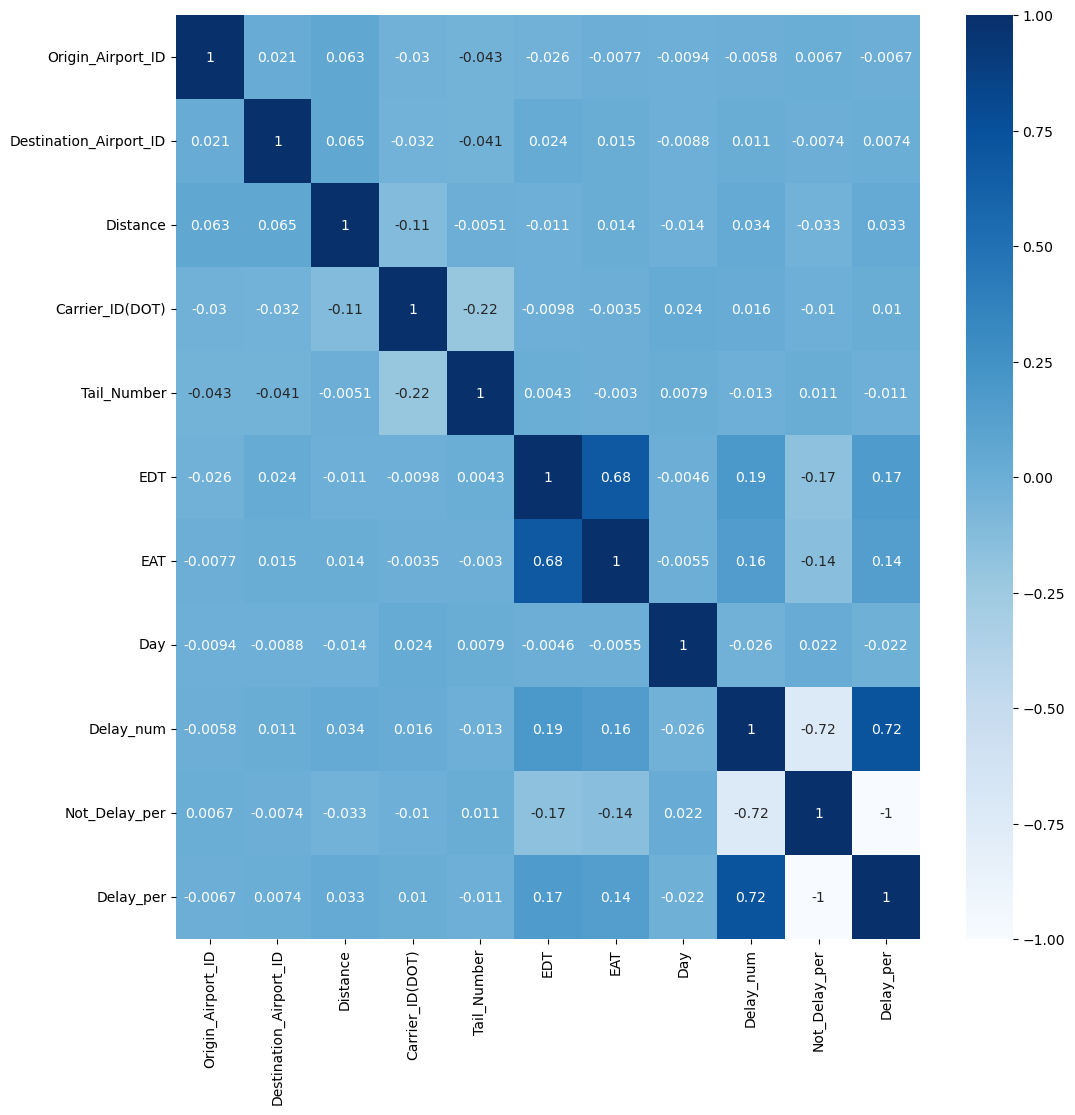

In [30]:
# 히트맵으로 상관관계 표시
plt.figure(figsize = (12,12))
sns.heatmap(train.drop(columns=['ID', 'Delay']).corr(), annot = True, cmap = 'Blues')
plt.show()

#### 전처리가 완료된 데이터를 csv, parquet 형태로 저장합니다.

In [31]:
# 전처리 코드를 여러 번 실행 하지 않기 위해서 csv, parquet 형식으로 한번 분리하였음
train_pre = pd.DataFrame(data=train, columns=train.columns, index=train.index)
train_pre.to_csv('train_pre.csv', index=False)

test_pre = pd.DataFrame(data=test, columns=test.columns, index=test.index)
test_pre.to_csv('test_pre.csv', index=False)

csv_to_parquet('./train_pre.csv', 'train_pre')
csv_to_parquet('./test_pre.csv', 'test_pre')

train_pre Done.
test_pre Done.


In [32]:
# 한 번 이상 전처리 코드를 실행했다면, 이 셀부터 실행하면 됨
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import random
import os
import gc

from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score

train = pd.read_parquet('./train_pre.parquet')
test = pd.read_parquet('./test_pre.parquet')
sample_submission = pd.read_csv('sample_submission.csv', index_col = 0)

## 모델 훈련 과정

#### 1. train 데이터의 입력 변수, 출력 변수,  test 데이터의 출력변수를 저장합니다.

In [33]:
train_x = train.drop(columns=['ID', 'Delay', 'Delay_num', 'Not_Delay_per', 'Delay_per'])
train_y = train['Delay_num'].astype('int64')
test_x = test.drop(columns=['ID'])

모든 입출력 변수의 데이터 타입이 int, float인 것을 확인합니다.

In [34]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976561 entries, 0 to 976560
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Origin_Airport_ID       976561 non-null  int64  
 1   Destination_Airport_ID  976561 non-null  int64  
 2   Distance                976561 non-null  int64  
 3   Carrier_ID(DOT)         976561 non-null  float64
 4   Tail_Number             976561 non-null  int64  
 5   EDT                     976561 non-null  int64  
 6   EAT                     976561 non-null  int64  
 7   Day                     976561 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 59.6 MB


In [35]:
train_y.sample(10)

361271    1
120143    0
628459    1
743124    1
582837    1
657567    1
325447    0
295441    0
15886     0
49583     1
Name: Delay_num, dtype: int64

In [36]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   Origin_Airport_ID       1000000 non-null  int64  
 1   Destination_Airport_ID  1000000 non-null  int64  
 2   Distance                1000000 non-null  int64  
 3   Carrier_ID(DOT)         1000000 non-null  float64
 4   Tail_Number             1000000 non-null  int64  
 5   EDT                     1000000 non-null  int64  
 6   EAT                     1000000 non-null  int64  
 7   Day                     1000000 non-null  int64  
dtypes: float64(1), int64(7)
memory usage: 61.0 MB


#### 2. 하이퍼 파라미터 튜닝을 수행합니다.¶
베이지안 최적화를 사용하여 XGBoost 모델의 최적 매개변수를 찾습니다.

In [37]:
# XGBoost 모델의 입력 데이터 형식인 DMatrix로 변환
dtrain = xgb.DMatrix(train_x, label=train_y)
dtest = xgb.DMatrix(test_x)

# XGBoost 모델의 목적 함수와 클래스 개수 설정
params = {
    'objective': 'multi:softprob',
    'num_class': len(sample_submission.columns)
}

# XGBoost 모델의 교차 검증 함수 정의 (전처리 과정에 있는 함수 정의와 동일함)
def xgb_cv(max_depth, learning_rate, n_estimators):
    params = {
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators)
    }
    xgb_clf = xgb.XGBClassifier(**params)
    cv_result = cross_val_score(xgb_clf, train_x, train_y, cv=3)
    return cv_result.mean()

# 베이지안 최적화 객체 생성
xgb_bo = BayesianOptimization(xgb_cv, {
    'max_depth': (3, 10),
    'learning_rate': (0.01, 0.3),
    'n_estimators': (100, 1000)
})

# 베이지안 최적화 수행
xgb_bo.maximize()
print("hyper-parameter tuning for model Done.")

|   iter    |  target   | learni... | max_depth | n_esti... |
-------------------------------------------------------------
| 1         | 0.6207    | 0.2223    | 7.261     | 451.1     |
| 2         | 0.625     | 0.05718   | 5.149     | 814.5     |
| 3         | 0.6249    | 0.2243    | 4.13      | 565.7     |
| 4         | 0.6234    | 0.2172    | 6.831     | 290.6     |
| 5         | 0.6238    | 0.1298    | 6.789     | 540.7     |
| 6         | 0.6251    | 0.1776    | 4.124     | 650.3     |
| 7         | 0.6249    | 0.04163   | 5.19      | 649.4     |
| 8         | 0.6249    | 0.1408    | 4.593     | 673.5     |
| 9         | 0.6222    | 0.181     | 6.926     | 784.0     |
| 10        | 0.6251    | 0.0332    | 4.662     | 837.2     |
| 11        | 0.6251    | 0.09321   | 4.095     | 595.1     |
| 12        | 0.6192    | 0.08889   | 9.969     | 871.4     |
| 13        | 0.6253    | 0.08265   | 3.047     | 711.3     |
| 14        | 0.6189    | 0.1079    | 9.779     | 735.2     |
| 15    

#### 3. 찾아낸 최적의 parameters를 이용해서, XGBoost 학습을 진행하여 모델을 훈련시킵니다.

In [38]:
# 최적 매개변수 저장
best_params = xgb_bo.max['params']

# 최적 매개변수 중 max_depth와 n_estimators를 정수로 변환
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])

# 목적 함수와 클래스 개수 설정
best_params['objective'] = 'multi:softprob'
best_params['num_class'] = len(sample_submission.columns)

# 최적 매개변수로 XGBoost 모델 훈련 및 모델 내보내기
bst = xgb.train(best_params, dtrain)
bst.save_model('model.bst')

# 레이블이 없는 데이터에 대한 예측값 생성
y_pred = bst.predict(dtest)

[14:11:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "n_estimators" } are not used.



In [39]:
import pickle

with open('model.pkl', 'wb') as model_file:
    pickle.dump(bst, model_file)

In [42]:
print(best_params)

{'learning_rate': 0.15293401487108357, 'max_depth': 3, 'n_estimators': 688, 'objective': 'multi:softprob', 'num_class': 2}


#### 4. 최종 제출 파일을 생성합니다.

In [40]:
# 예측값을 submission 데이터 프레임으로 저장
submission = pd.DataFrame(data=y_pred, columns=sample_submission.columns, index=sample_submission.index)

# submission 데이터 프레임을 CSV 파일로 출력
submission.to_csv('FlightDelayPrediction_submission_pre_tune.csv', index=True)

해당 제출 파일으로, 대회 종료 시점 기준으로 Public 0.62347점으로 7등을 달성하였습니다.
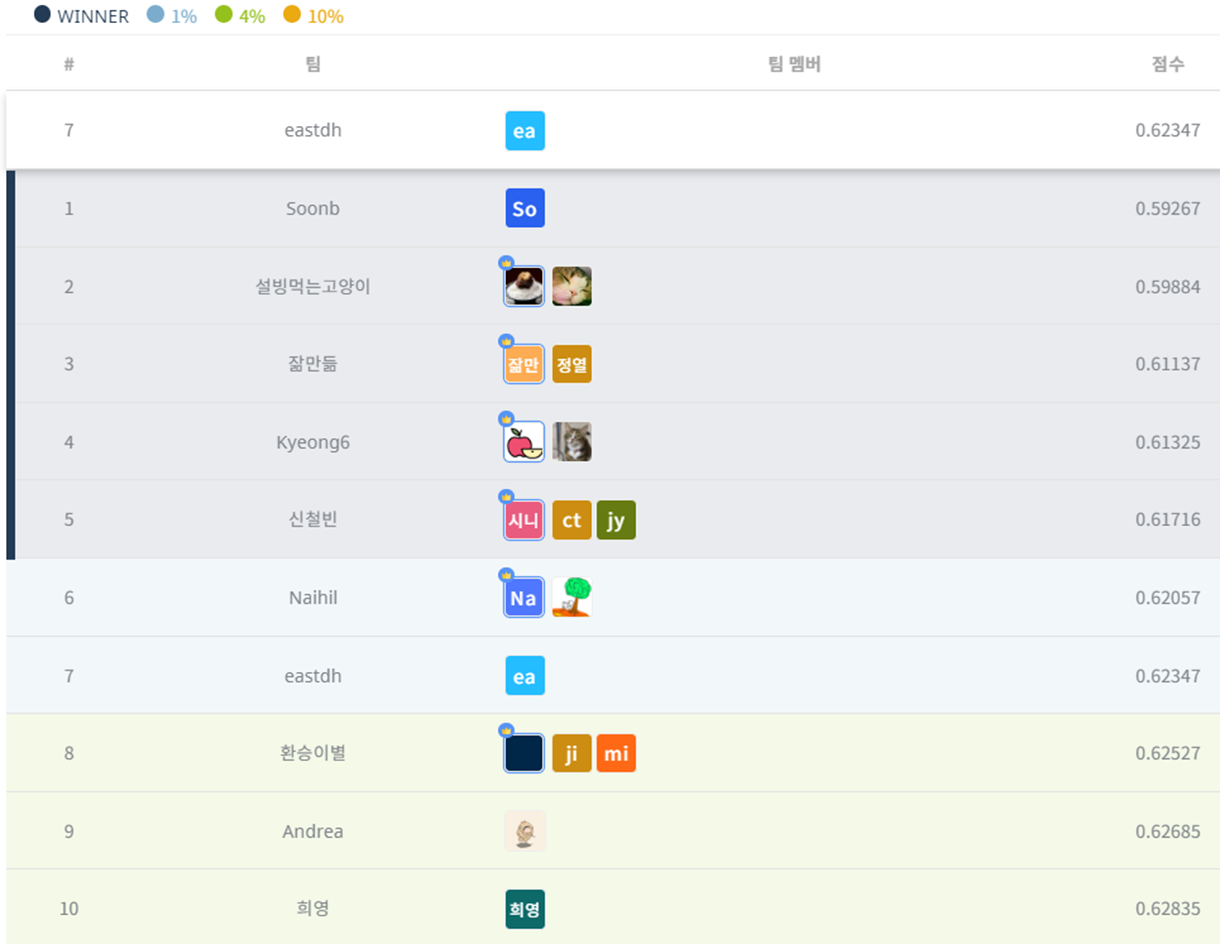

In [41]:
time_end = time.time()
sec = (time_end - time_start)
print("수행 시간:", datetime.timedelta(seconds=sec))
print('종료 시각:', time.strftime('%Y.%m.%d - %H:%M:%S'))

수행 시간: 1:29:01.465466
종료 시각: 2023.06.02 - 14:11:53
